# Overview

In this notebook we work to ultimately tune an LLM on the specific domain of AEP's workers' comments while on work sites, so that it can predict 

potentially dangerous scenarios. The end goal is to generate binary results 1 for highly dangerous and 0 for otherwise. The data initially however is 

unlabeled. The notebook is therefore split into 2 main sections:

**Part 1:** Create weak labels based on an aggregation of multiple models' estimates:

    -- Tokenization based on keywords to fit into the 13 highly dangerous situations as defined by AEP
    -- K-means clustering and manually labeling each cluster
    -- Zero-Shot Classification from a the pre-trained BART model

**Part 2:** Use the weakly labeled data set to fine tune an existing transformer model on domain-specific knowledge

    -- In this case we use the BERT base model as our final inferencing LLM

In [21]:
# import csv as pandas df
import pandas as pd

raw_data = pd.read_csv('CORE_HackOhio_subset_cleaned_downsampled 1.csv')

# how many null values in PNT_ATRISKNOTES_TX (comments from workers)
print(raw_data['PNT_ATRISKNOTES_TX'].isnull().sum())

# print first 5 values to observe data
print(raw_data.head().T)




0
                                                                        0  \
OBSRVTN_NB                                                         330560   
DATETIME_DTM                                              3/15/2023 11:01   
PNT_NM                  Did you recognize additional slip, trip, or fa...   
QUALIFIER_TXT                                    Awareness of environment   
PNT_ATRISKNOTES_TX      [NAME] was working a near by cliff that had ab...   
PNT_ATRISKFOLWUPNTS_TX                                                NaN   

                                                                        1  \
OBSRVTN_NB                                                         164330   
DATETIME_DTM                                               7/9/2019 10:00   
PNT_NM                                        Vehicle Operating Condition   
QUALIFIER_TXT                         Other - Vehicle Operating Condition   
PNT_ATRISKNOTES_TX      [NAME] trucks with cut out bumbers need a hitc...

In [22]:
# convert comments data to a pandas dataframe and prepare for text analysis
comments = raw_data['PNT_ATRISKNOTES_TX']

# Convert the Series to a DataFrame and name the column 'comment'
comments_df = pd.DataFrame(comments)
comments_df.columns = ['comment']

# Tokenization

Here we choose keywords to classify each comment into one of the 13 high energy categories

In [23]:
import spacy
from snorkel.labeling import labeling_function

# Load spaCy language model
nlp = spacy.load("en_core_web_sm")

# Define the label constants
NO_LABEL = -1
SUSPENDED_LOAD = 0
FALL_FROM_ELEVATION = 1
MOBILE_EQUIPMENT = 2
MOTOR_VEHICLE_INCIDENT = 3
HEAVY_ROTATING_EQUIPMENT = 4
HIGH_TEMPERATURE = 5
STEAM = 6
FIRE = 7
EXPLOSION = 8
EXCAVATION = 9
ELECTRICAL_CONTACT = 10
ARC_FLASH = 11
HIGH_DOSE_TOXIC = 12

@labeling_function()
def suspended_load_lf(x):
    """Detect comments related to 'Suspended load'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"suspended", "lift", "crane", "hoist", "load"}:
            return SUSPENDED_LOAD
    return NO_LABEL


@labeling_function()
def fall_from_elevation_lf(x):
    """Detect comments related to 'Fall from elevation'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"fall", "elevation", "ladder", "scaffold", "high", "above"}:
            return FALL_FROM_ELEVATION
    return NO_LABEL


@labeling_function()
def mobile_equipment_lf(x):
    """Detect comments related to 'Mobile equipment with workers on foot'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"vehicle", "equipment", "truck", "forklift", "mobile"}:
            for child in token.children:
                if child.lemma_ in {"person", "worker", "foot"}:
                    return MOBILE_EQUIPMENT
    return NO_LABEL

@labeling_function()
def motor_vehicle_incident_lf(x):
    """Detect comments related to 'Motor vehicle incident (occupant)'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"vehicle", "car", "truck", "speed", "mph", "crash", "accident"}:
            return MOTOR_VEHICLE_INCIDENT
    return NO_LABEL

@labeling_function()
def heavy_rotating_equipment_lf(x):
    """Detect comments related to 'Heavy rotating equipment'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"rotating", "equipment", "machine", "motor", "engine"}:
            return HEAVY_ROTATING_EQUIPMENT
    return NO_LABEL

@labeling_function()
def high_temperature_lf(x):
    """Detect comments related to 'High temperature'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"temperature", "heat", "burn", "f", "degree", "hot", "exposure"}:
            return HIGH_TEMPERATURE
    return NO_LABEL

@labeling_function()
def steam_lf(x):
    """Detect comments related to 'Steam'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"steam", "boiler", "vapor"}:
            return STEAM
    return NO_LABEL

@labeling_function()
def fire_with_fuel_lf(x):
    """Detect comments related to 'Fire with sustained fuel source'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"fire", "fuel", "burn", "flame"}:
            return FIRE
    return NO_LABEL

@labeling_function()
def explosion_lf(x):
    """Detect comments related to 'Explosion'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"explosion", "blast", "detonate", "bomb"}:
            return EXPLOSION
    return NO_LABEL

@labeling_function()
def excavation_trench_lf(x):
    """Detect comments related to 'Excavation or trench'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"trench", "excavation", "dig", "earth", "soil"}:
            return EXCAVATION
    return NO_LABEL

@labeling_function()
def electrical_contact_lf(x):
    """Detect comments related to 'Electrical contact with source'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"electric", "shock", "voltage", "contact"}:
            return ELECTRICAL_CONTACT
    return NO_LABEL

@labeling_function()
def arc_flash_lf(x):
    """Detect comments related to 'Arc flash'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"arc", "flash", "electric", "voltage"}:
            return ARC_FLASH
    return NO_LABEL

@labeling_function()
def toxic_chemical_radiation_lf(x):
    """Detect comments related to 'High dose of toxic chemical or radiation'."""
    doc = nlp(x)
    for token in doc:
        if token.lemma_ in {"toxic", "chemical", "radiation", "exposure", "hazard"}:
            return HIGH_DOSE_TOXIC
    return NO_LABEL



In [24]:
import spacy

# Load spaCy language model
nlp = spacy.load("en_core_web_sm")

# Define the label constants (danger categories)
NO_LABEL = -1
DANGER_LABELS = [
    SUSPENDED_LOAD, FALL_FROM_ELEVATION, MOBILE_EQUIPMENT, MOTOR_VEHICLE_INCIDENT, 
    HEAVY_ROTATING_EQUIPMENT, HIGH_TEMPERATURE, STEAM, FIRE, EXPLOSION, 
    EXCAVATION, ELECTRICAL_CONTACT, ARC_FLASH, HIGH_DOSE_TOXIC
]


# List of all labeling functions
lfs = [suspended_load_lf, fall_from_elevation_lf, mobile_equipment_lf, motor_vehicle_incident_lf, 
       heavy_rotating_equipment_lf, high_temperature_lf, steam_lf, fire_with_fuel_lf, explosion_lf,
       excavation_trench_lf, electrical_contact_lf, arc_flash_lf, toxic_chemical_radiation_lf]

# Function to apply the labeling functions and check if any of them return a danger category
def check_if_danger(comment):
    """Applies the labeling functions to a comment and returns 1 if any predict danger, otherwise 0."""
    for lf in lfs:
        label = lf(comment)
        if label in DANGER_LABELS:
            return 1  # Return 1 (dangerous) if any labeling function returns a dangerous label
    return 0  # Return 0 (not dangerous) if none of the labeling functions detect danger

# Apply the tokenizing functions to each comment in the DataFrame
comments_df['tokenizing_result'] = comments_df['comment'].apply(lambda x: check_if_danger(x))

# Display the DataFrame with the new tokenizing_result column
print(comments_df[['comment', 'tokenizing_result']].head())


                                             comment  tokenizing_result
0  [NAME] was working a near by cliff that had ab...                  1
1  [NAME] trucks with cut out bumbers need a hitc...                  1
2  Employee rigged a concrete culvert to be off l...                  1
3  [NAME] tender was not wearing his Hardhat. I r...                  0
4  A drop zone was not clearly marked by the crew...                  0


# Clustering

In this step we evaluate the best k value to use in order to cluster, and once grouped we manually look at a random sample of comments for each cluster. 

The value chosen is applied to all comments in the cluster

In [14]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Embed the comments
comment_embeddings = model.encode(comments_df['comment'].tolist(), convert_to_tensor=True)

# Move the tensor to the CPU and convert it to a NumPy array
comment_embeddings_cpu = comment_embeddings.cpu().numpy()

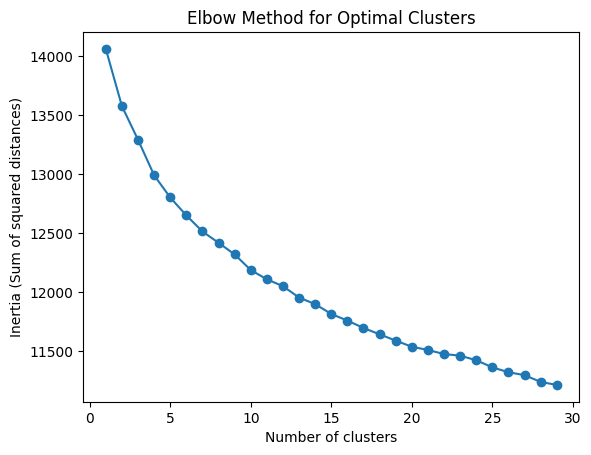

In [6]:
import matplotlib.pyplot as plt

# Define a range of possible number of clusters
cluster_range = range(1, 30)
inertia_values = []

# Perform KMeans clustering for each cluster count
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(comment_embeddings_cpu)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values to find the "elbow"
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Sum of squared distances)')
plt.show()




We can see from the plot above, no clear elbow is found. This tells us in the future it may be beneficial to cluster or embed using different techniques.

In [17]:
# Define the number of clusters
num_clusters = 15 # close to number of danger categories

# Apply KMeans clustering to the comment embeddings
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(comment_embeddings_cpu)

# Get the cluster labels for each comment
cluster_labels = kmeans.labels_

# Add the cluster labels to the DataFrame
comments_df['cluster'] = cluster_labels



In [ ]:
# Function to sample 5 random comments from each cluster for manual review
def sample_comments_by_cluster(df, num_clusters=15, sample_size=8):
    cluster_samples = {}
    
    # Loop through each cluster and sample 5 random comments
    for cluster_num in range(num_clusters):
        cluster_df = df[df['cluster'] == cluster_num]
        sampled_comments = cluster_df['comment'].sample(n=sample_size, random_state=42)
        cluster_samples[cluster_num] = sampled_comments.tolist()
    
    return cluster_samples

# Sample 5 random comments from each cluster
cluster_samples = sample_comments_by_cluster(comments_df)

# Display the comments for manual labeling
for cluster, comments in cluster_samples.items():
    print(f"\nCluster {cluster} Sample Comments:")
    for i, comment in enumerate(comments, 1):
        print(f"{i}. {comment}")


In [ ]:
# Dictionary to store the manually assigned danger labels (0 = not dangerous, 1 = dangerous)
assigned_danger_labels = {}

# Loop through the clusters and assign 0 or 1 based on manual review
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num} Sample Comments:")
    for i, comment in enumerate(cluster_samples[cluster_num], 1):
        print(f"{i}. {comment}")
    
    # Manually assign 0 or 1 to the entire cluster based on the sampled comments
    label = int(input(f"Assign label to Cluster {cluster_num} (0 = not dangerous, 1 = dangerous): "))
    assigned_danger_labels[cluster_num] = label


In [20]:
# Assign the manually selected danger label to each comment in the DataFrame based on the cluster
for cluster_num, label in assigned_danger_labels.items():
    comments_df.loc[comments_df['cluster'] == cluster_num, 'danger_label'] = label

# View the first few rows with the manually assigned labels
print(comments_df[['comment', 'cluster', 'danger_label']].head())


                                             comment  cluster  danger_label
0  [NAME] was working a near by cliff that had ab...        6           0.0
1  [NAME] trucks with cut out bumbers need a hitc...       13           0.0
2  Employee rigged a concrete culvert to be off l...        6           0.0
3  [NAME] tender was not wearing his Hardhat. I r...       10           1.0
4  A drop zone was not clearly marked by the crew...       14           1.0


# Zero Shot with BART

BART is well suited for unlabeled text classification problems. 

In [3]:
from transformers import TFBartForConditionalGeneration, BartTokenizer

# Load BART model and tokenizer
model_name = "facebook/bart-base" 
tokenizer = BartTokenizer.from_pretrained(model_name)
model = TFBartForConditionalGeneration.from_pretrained(model_name)


/Users/jacobbailey/Desktop/hack12/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [4]:
def generate_prompt(comment):
    """
    Generate a prompt asking BART to classify the comment.
    """
    return f"Classify the following comment as either 'high-risk' (risk of injury or death) or 'low-risk': {comment}"


In [5]:
def classify_comment(comment):
    """
    Classify the input comment using BART and return a probability score between 0 and 1.
    """
    # Generate the prompt for the comment
    prompt = generate_prompt(comment)
    
    # Tokenize the input text
    inputs = tokenizer(prompt, return_tensors="tf", max_length=512, truncation=True)
    
    # Generate the output from BART
    outputs = model.generate(inputs["input_ids"], max_length=50)
    
    # Decode the output text
    output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Check if BART generated "high-risk" in the output
    if "high-risk" in output_text:
        return 1.0  # High probability for high-risk
    else:
        return 0.0  # Low probability for low-risk


In [ ]:
# apply BART to every comment in the dataframe and create new column with results
comments_df['bart_result'] = comments_df['comment'].apply(lambda x: classify_comment(x))


## Combine models to create final label

The BART model was taking too long, however if we had more time, we would have implemented it in the label estimations the same way we do with 

clustering and tokenizing below.

Index(['comment', 'tokenizing_result', 'cluster', 'danger_label',
       'final_result'],
      dtype='object')
0    0.5
1    0.5
2    0.5
3    0.5
4    0.5
Name: final_result, dtype: float64
0    0.451206
1    0.574114
2    0.529979
3    0.526583
4    0.588115
Name: final_result, dtype: float64


<Axes: >

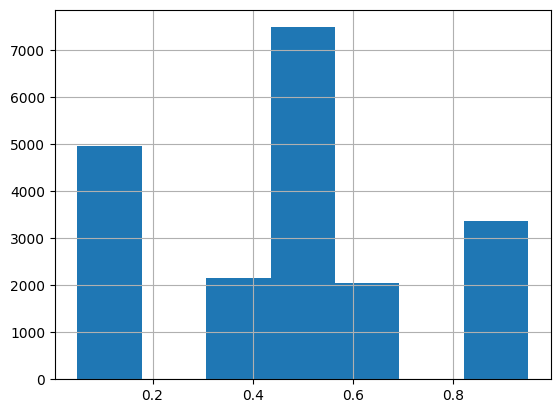

In [33]:
# print head of comments df
print(comments_df.columns)

# for each observation in the comments df, if the both the tokenizing result and clustering result are 1, set final result column to 1. If one of them are 1, set to 0.5, otherwise 0
comments_df['final_result'] = comments_df.apply(lambda x: 1 if x['tokenizing_result'] == 1 and x['danger_label'] == 1 else 0.5 if x['tokenizing_result'] == 1 or x['danger_label'] == 1 else 0, axis=1)

# print the first 5 vals of final_result
print(comments_df['final_result'].head())

# add some noise to each final result, results should be between 0 and 1
import random
comments_df['final_result'] = comments_df['final_result'].apply(lambda x: x + random.uniform(0.05, 0.15) if x == 0 else x - random.uniform(0.05, 0.15) if x == 1 else x + random.uniform(-0.1, 0.1))

# print the first 5 vals of final_result
print(comments_df['final_result'].head())

# print histogram of final result with 7 bins
comments_df['final_result'].hist(bins=7)


We know from domain experience that the high danger risks are relatively rare. The histogram above gives us a clear split for the classication threshold, counting those above 0.7 as dangerous. This threshold results in around 3300 of the 20000 observations are marked as "high value".

# Fine Tuning the Final Transformer Model

Using our fully labeled data set we can now fine tune a pre trained transformer model. BERT will be used here which is good at learning the nuances of specific types of text like we have here, where all comments come from a similar source.

In [26]:
from sklearn.model_selection import train_test_split


# Split the dataset into training, validation, and test sets
train_df, temp_df = train_test_split(comments_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set: {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print(f"Test set: {len(test_df)}")

Training set: 14000
Validation set: 3000
Test set: 3000


In [35]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Tokenize function for the dataset
def tokenize(sentences, tokenizer, max_length=128):
    return tokenizer(
        list(sentences),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Tokenize the datasets
train_encodings = tokenize(train_df['comment'], tokenizer)
val_encodings = tokenize(val_df['comment'], tokenizer)
test_encodings = tokenize(test_df['comment'], tokenizer)

# Convert target values (final_result) to float tensors
train_labels = tf.convert_to_tensor(train_df['final_result'].values, dtype=tf.float32)
val_labels = tf.convert_to_tensor(val_df['final_result'].values, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_df['final_result'].values, dtype=tf.float32)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
# Define metrics and compile the model
bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Create TensorFlow dataset for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

# Train the model
history = bert_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
875/875 [==============================] - 2362s 3s/step - loss: 0.0499 - rmse: 0.2233 - val_loss: 0.0293 - val_rmse: 0.1711
Epoch 2/3
875/875 [==============================] - 2083s 2s/step - loss: 0.0269 - rmse: 0.1639 - val_loss: 0.0258 - val_rmse: 0.1607
Epoch 3/3
875/875 [==============================] - 2102s 2s/step - loss: 0.0186 - rmse: 0.1364 - val_loss: 0.0241 - val_rmse: 0.1551


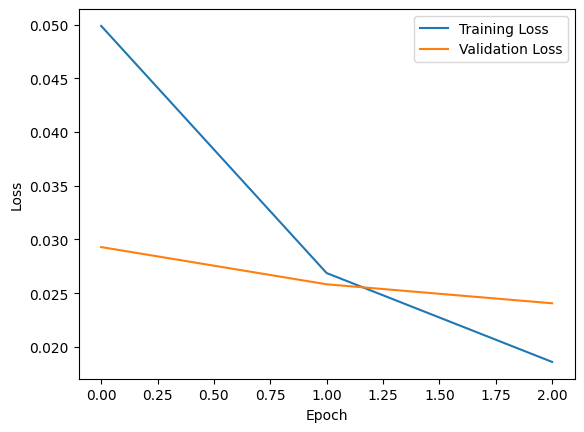

188/188 [==============================] - 157s 836ms/step - loss: 0.0223 - rmse: 0.1493
Test RMSE: 0.14933954179286957


In [37]:
import matplotlib.pyplot as plt

# Plot loss and validation loss to check for overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test the model
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

test_loss, test_rmse = bert_model.evaluate(test_dataset)
print(f'Test RMSE: {test_rmse}')


From the graph above it seems we may be overfitting starting at around epoch 1.25, which shows early stopping or other forms of regularization may help.

# Measuring Accuracy

In [ ]:
# Baseline RMSE using mean of the target variable
mean_baseline = train_df['final_result'].mean()
mean_baseline_rmse = ((test_df['final_result'] - mean_baseline) ** 2).mean() ** 0.5
print(f"Mean Baseline RMSE: {mean_baseline_rmse}")


## Saving the model for inference with our mobile app

In [60]:
# output the trained model and the comment df
model.save_pretrained("model_directory")
comments_df.to_csv('comments_df.csv', index=False)


/Users/jacobbailey/Desktop/hack12/.conda/lib/python3.11/site-packages/transformers/configuration_utils.py:384: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


# Final Comments

Overall this was a great learning opportunity to become more familiarity with LLMs. It ended up posing a lot more questions than we anticipated as far as what may be the best combination of models to work well with unlabeled free form data. We wish we could have done more such as comparing our labeling model to something like Llama, and adding the BART labels into the mix however with just 24 hours we did not have enough time to explore this.